In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [2]:
df = pd.read_csv('labels.csv', index_col=0)

# Appropriate classes for multitype classification

In [46]:
classes = [(0,1), (1, 10), (10, 50), (50, 100), (100, 500), (500, 1000), (1000, 2000),(2000, 11000)]
counts= pd.Series(np.zeros(len(classes), dtype = int),index=classes)

In [47]:
for entry in np.nditer(df.as_matrix()):
    for cl in classes:
        if (entry > cl[0]) and (entry <= cl[1]):
            counts[cl] += 1    

In [48]:
counts

(0, 1)            110
(1, 10)           782
(10, 50)         2813
(50, 100)         908
(100, 500)       1294
(500, 1000)       529
(1000, 2000)      401
(2000, 11000)     119
dtype: int64

These classes all contain sufficiently many locations.

# Test - Train split and sorting images into libraries

In [8]:
# Requires that data is in
#
# C:/Data/images
#
# And need to create /Data/test
# and /Data/train directories

datadir = os.getcwd() + '/Data'
imagedir = datadir + '/images'
traindir = datadir + '/train'
valdir = datadir + '/val'

In [51]:
for cl in classes:
    val_dirname = valdir + '/' + str(cl[0]) + '_' + str(cl[1])
    train_dirname = traindir + '/' + str(cl[0]) + '_' + str(cl[1])
    if not os.path.exists(val_dirname): os.mkdir(val_dirname)
    if not os.path.exists(train_dirname): os.mkdir(train_dirname)

In [52]:
test_rate = 0.2

In [53]:
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if np.random.random() > test_rate:
            target_dir = traindir
        else:
            target_dir = valdir
            
        entry = df.iloc[i,j]
        
        for cl in classes:
            if (entry >= cl[0]) and (entry <= cl[1]):
                target_dir = target_dir + '/' + str(cl[0]) + '_' + str(cl[1]) + '/'
        
        shutil.copy(imagedir + '/' + str(99-i) + '_' + str(j) +'.png', target_dir)

# Using the pretrained neural network

In [1]:
from vgg16 import Vgg16

Using Theano backend.


In [38]:
vgg = Vgg16()
batch_size = 100

In [121]:
batches = vgg.get_batches(traindir, batch_size=batch_size)
val_batches = vgg.get_batches(testdir, batch_size=batch_size)
vgg.finetune(batches)

Found 5560 images belonging to 8 classes.
Found 1440 images belonging to 8 classes.


In [41]:
vgg.fit(batches, test_batches, nb_epoch=10)

Epoch 1/10
5560/5560 [==============================] - 1894s - loss: 1.9767 - acc: 0.4239 - val_loss: 1.2079 - val_acc: 0.5674
Epoch 2/10
5560/5560 [==============================] - 1962s - loss: 1.5603 - acc: 0.4984 - val_loss: 1.1344 - val_acc: 0.5889
Epoch 3/10
5560/5560 [==============================] - 1946s - loss: 1.4018 - acc: 0.5176 - val_loss: 1.1179 - val_acc: 0.6028
Epoch 4/10
5560/5560 [==============================] - 1871s - loss: 1.3323 - acc: 0.5311 - val_loss: 1.0842 - val_acc: 0.5840
Epoch 5/10
5560/5560 [==============================] - 1883s - loss: 1.2687 - acc: 0.5455 - val_loss: 1.0092 - val_acc: 0.6194
Epoch 6/10
5560/5560 [==============================] - 1885s - loss: 1.1849 - acc: 0.5536 - val_loss: 1.0658 - val_acc: 0.6062
Epoch 7/10
5560/5560 [==============================] - 1889s - loss: 1.2053 - acc: 0.5588 - val_loss: 1.0313 - val_acc: 0.6083
Epoch 8/10
5560/5560 [==============================] - 1892s - loss: 1.1565 - acc: 0.5651 - val_loss: 1

In [42]:
vgg.fit(batches, test_batches, nb_epoch=20)

Epoch 1/20
5560/5560 [==============================] - 1894s - loss: 1.1073 - acc: 0.5831 - val_loss: 1.0189 - val_acc: 0.6083
Epoch 2/20
5560/5560 [==============================] - 1898s - loss: 1.0903 - acc: 0.5933 - val_loss: 1.0156 - val_acc: 0.6090
Epoch 3/20
5560/5560 [==============================] - 1880s - loss: 1.0927 - acc: 0.5845 - val_loss: 1.0024 - val_acc: 0.6062
Epoch 4/20
5560/5560 [==============================] - 1873s - loss: 1.0621 - acc: 0.6013 - val_loss: 1.0025 - val_acc: 0.6035
Epoch 5/20
5560/5560 [==============================] - 1866s - loss: 1.0411 - acc: 0.6016 - val_loss: 1.0265 - val_acc: 0.6076
Epoch 6/20
5560/5560 [==============================] - 1880s - loss: 1.0308 - acc: 0.6018 - val_loss: 0.9889 - val_acc: 0.6215
Epoch 7/20
5560/5560 [==============================] - 1842s - loss: 1.0521 - acc: 0.6041 - val_loss: 1.0643 - val_acc: 0.5979
Epoch 8/20
5560/5560 [==============================] - 1840s - loss: 1.0409 - acc: 0.6047 - val_loss: 0

In [43]:
vgg.model.save_weights('zsolt.h5')

# Visualizing results

# Some helper functions first

In [149]:
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    acc=int(100*np.diag(cm).sum()/float(cm.sum()))/100.0
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('{}, Accuracy={}'.format(title,acc))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = round(100 * cm[i,j])/100.0
        plt.text(j, i, text, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [ ]:
val_data = get_data(testdir)
val_classes = val_batches.classes

In [76]:
val_pred_scores = vgg.model.predict(val_data, batch_size=batch_size, verbose = 1)

Found 1440 images belonging to 8 classes.
1440/1440 [==============================] - 260s   


In [89]:
val_prediction = [val_pred_scores[i].argmax() for i in range(len(val_pred_scores))]

In [94]:
cm = confusion_matrix(val_classes, val_prediction)

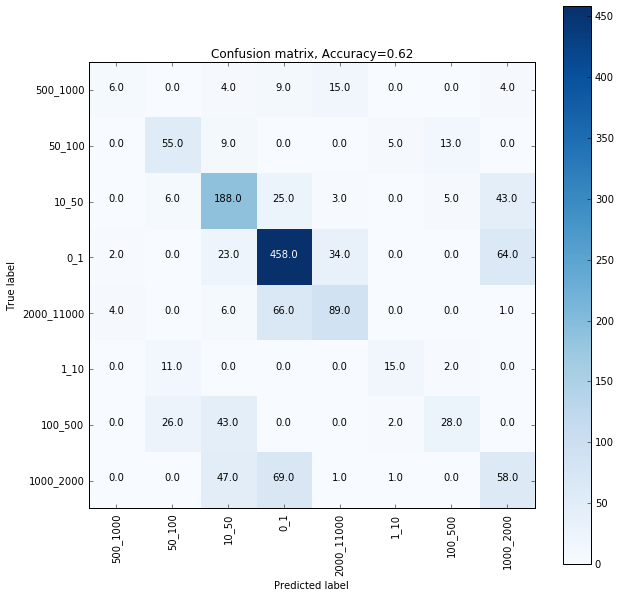

In [150]:
plot_confusion_matrix(cm, val_batches.class_indices, normalize = False)

# Retraining last two dense layers

Here, we create another vgg model, where instead of just finetuning (i.e. retraining the last layer), we retrain the last two Dense layers.

In [151]:
from keras.layers.core import Dense
from keras.optimizers import SGD, RMSprop, Adam

In [154]:
vgg2 = Vgg16()
vgg2.model.pop()
for layer in vgg2.model.layers: layer.trainable=False
vgg2.model.add(Dense(8, activation='softmax'))
vgg2.model.layers[-3].trainable = True

In [155]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.n, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.n)

In [156]:
opt = Adam(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fit_model(model, batches, val_batches, nb_epoch=20)

Epoch 1/20
 400/5560 [=>............................] - ETA: 971s - loss: 10.0335 - acc: 0.3775